In [2]:
library(data.table,quietly = TRUE,warn.conflicts = FALSE)
library(ggplot2,quietly = TRUE,warn.conflicts = FALSE)
library(lubridate,quietly = TRUE,warn.conflicts = FALSE)
library(forecast,quietly = TRUE,warn.conflicts = FALSE)
library(urca,quietly = TRUE,warn.conflicts = FALSE)
library(plotly,quietly = TRUE,warn.conflicts = FALSE)
library(scatterplot3d,quietly = TRUE,warn.conflicts = FALSE)
library(rpart,quietly = TRUE,warn.conflicts = FALSE)
library(rattle,quietly = TRUE,warn.conflicts = FALSE)
library(genlasso,quietly = TRUE,warn.conflicts = FALSE)
library(modelr)
library(resamplr)
library(caret)
library(zoo)
library(plyr)
options(repr.plot.width=10, repr.plot.height=8)
library(TunePareto)
require(rpart)
require(rattle)

In [3]:
setwd(getwd())
data = fread("bulk_imbalance.csv")
data[,time:=as.POSIXct(paste(date, hour), format="%Y-%m-%d %H")]

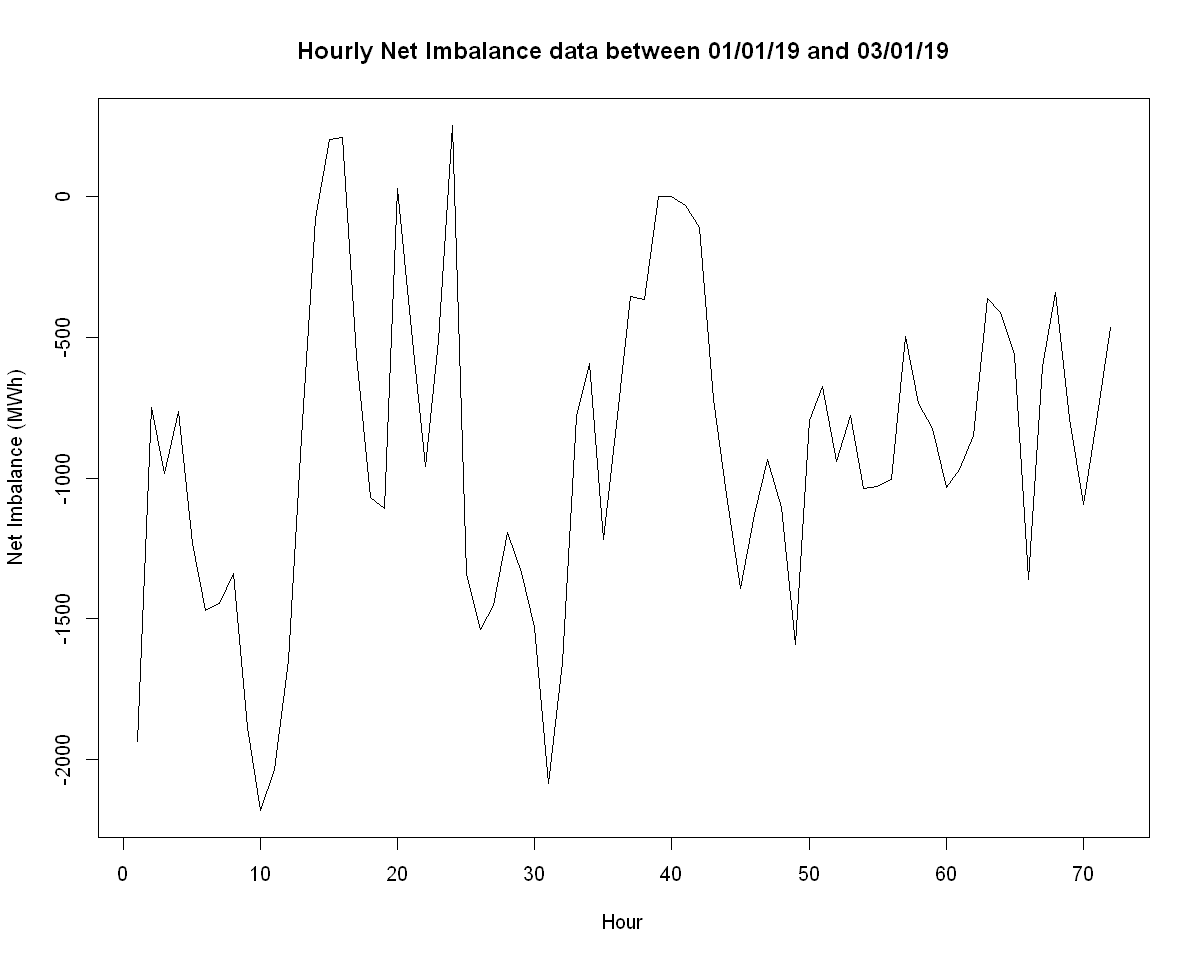

In [4]:
plot(data$net[1:72],
     xlab = "Hour",
     ylab = "Net Imbalance (MWh)",
     main = "Hourly Net Imbalance data between 01/01/19 and 03/01/19",
     type = 'l')

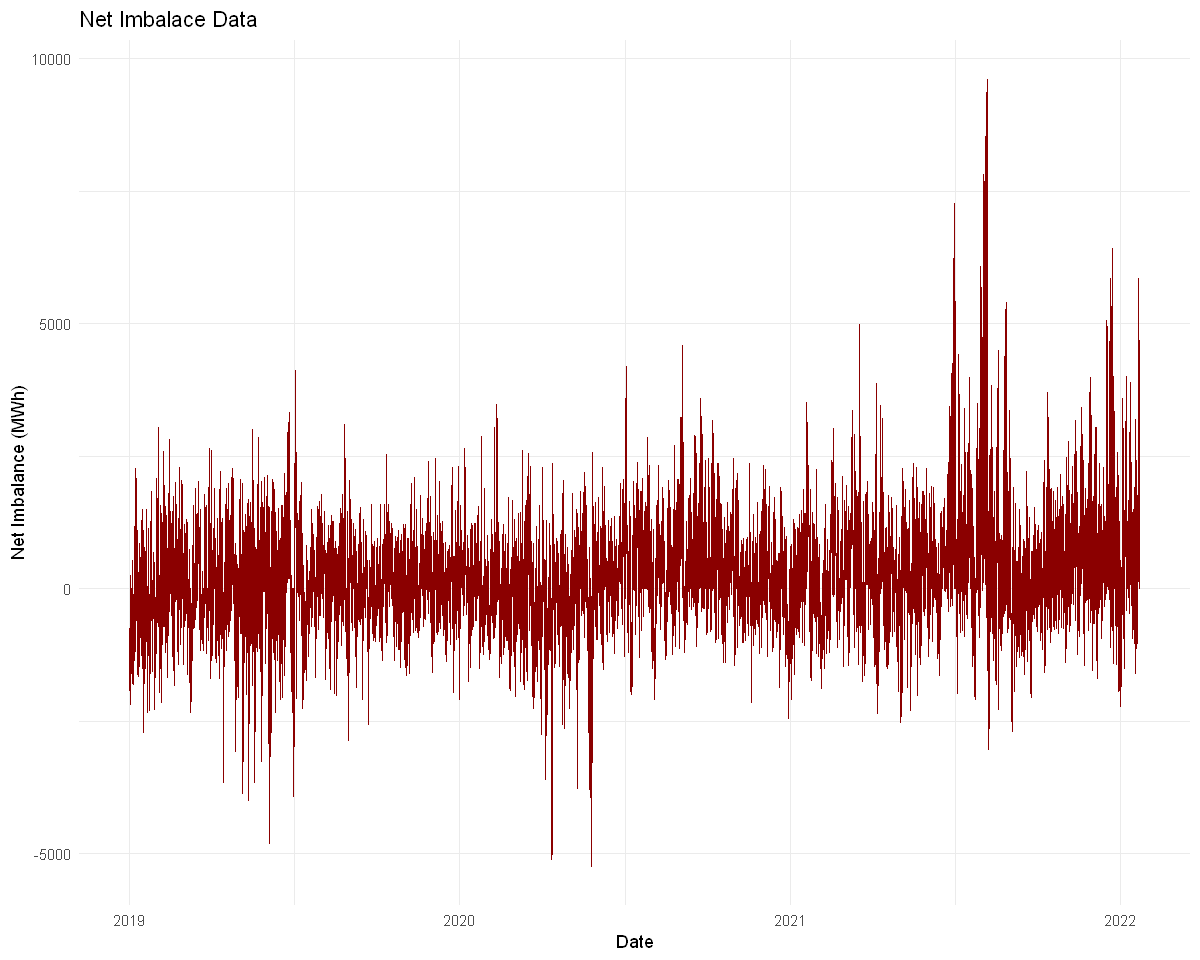

In [5]:
ggplot(data ,aes(x=time,y=net)) + geom_line(color= "darkred") +
labs(title = "Net Imbalace Data",
       x = "Date",
       y= "Net Imbalance (MWh)") +
  theme_minimal()

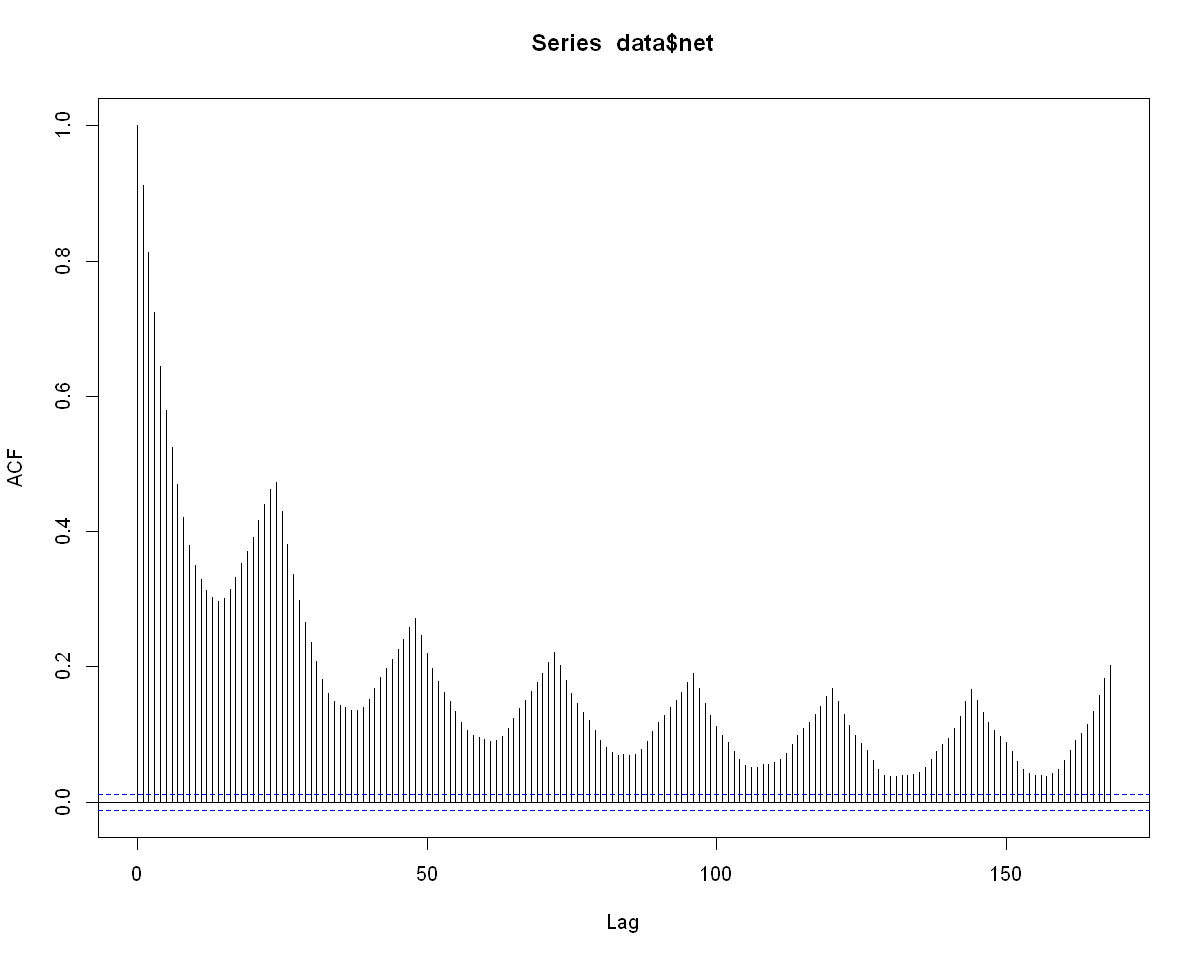

In [7]:
acf(data$net,168)

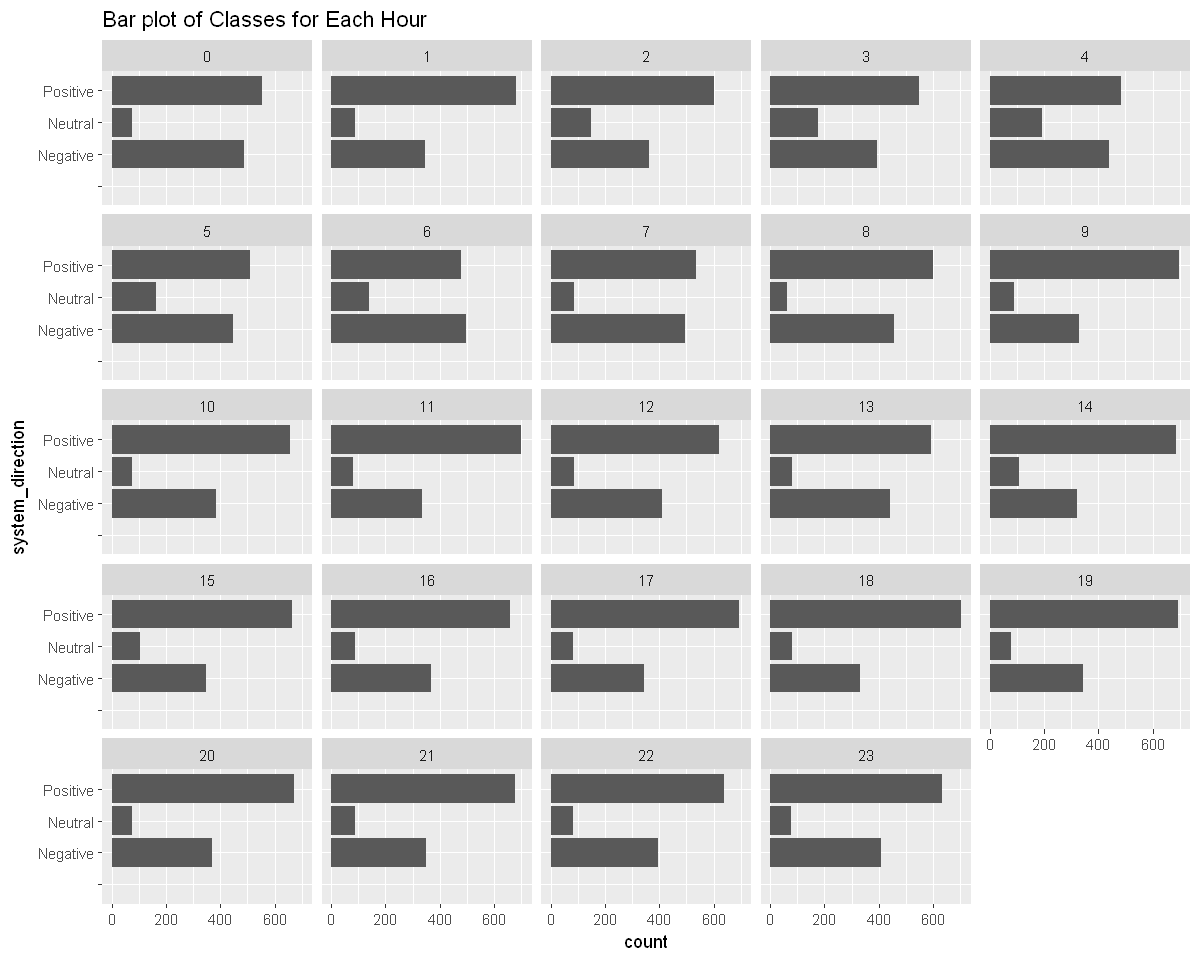

In [8]:
ggplot(data, aes(y=system_direction)) +
geom_bar() +
labs(title = "Bar plot of Classes for Each Hour") +
facet_wrap(~ hour)

In [9]:
weather_4 = fread("2022-01-22_weather.csv")

In [10]:
weather_4 = weather_4[(weather_4$date >= min(data$date))]
weather_4 = weather_4[(weather_4$date <= max(data$date))]

In [11]:
unique(weather_4$variable)

[1] "DSWRF_surface"        "RH_2.m.above.ground"  "TMP_2.m.above.ground"
[4] "TCDC_low.cloud.layer" "ws_10m"               "wdir_10m"

In [12]:
for(i in 1:6){
       data = cbind(data,weather_4[variable == unique(weather_4$variable)[i],mean(value),by = .(date,hour)]$V1)
}


In [13]:
for(i in 1:6){
colnames(data)[13 + i] = paste(unique(weather_4$variable)[i])
}

In [14]:
data[,weekdays:=weekdays(date)]
data[,months:=as.factor(month(date))]
data[,years:=as.factor(year(date))]
data[,trend:=1:.N]
data[,lag_1:=shift(net,1)]

In [15]:
train_data = data[date <= "2022-01-08"]


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour), 
    data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-5405.8  -564.5   -23.7   516.4  8483.7 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -285.71731   41.14629  -6.944 3.90e-12 ***
weekdaysMonday     -22.40094   22.82068  -0.982 0.326302    
weekdaysSaturday  -124.63683   22.78597  -5.470 4.54e-08 ***
weekdaysSunday    -345.70082   22.81924 -15.150  < 2e-16 ***
weekdaysThursday    67.92089   22.78130   2.981 0.002872 ** 
weekdaysTuesday     41.08477   22.78427   1.803 0.071367 .  
weekdaysWednesday   23.49126   22.78271   1.031 0.302503    
months2             97.25624   36.72218   2.648 0.008091 ** 
months3             12.02477   50.83108   0.237 0.812997    
months4           -150.76248   69.26475  -2.177 0.029518 *  
months5            -94.08395   88.77904  -1.060 0.289266    
months6             82.77239  109.06331   0.759 0.447896

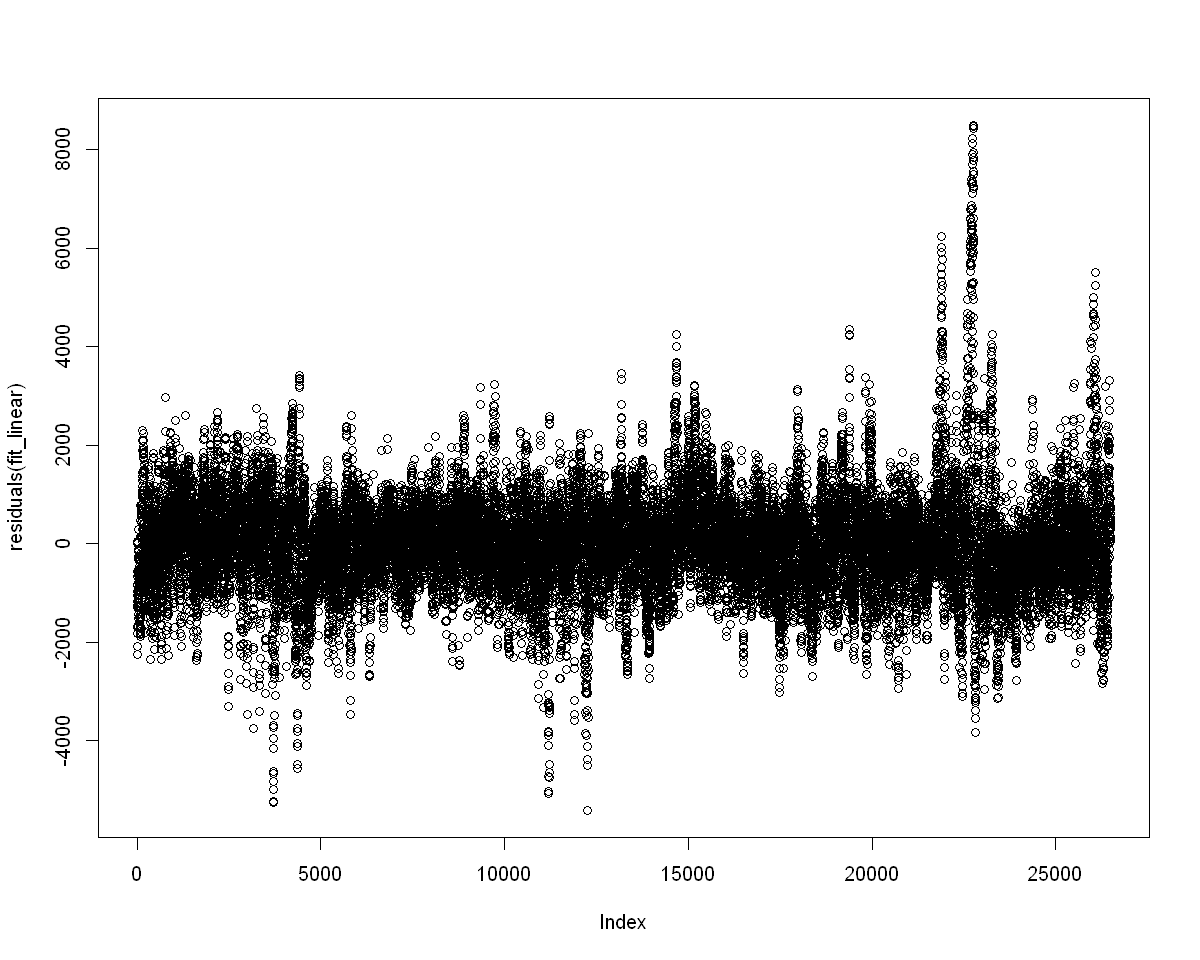

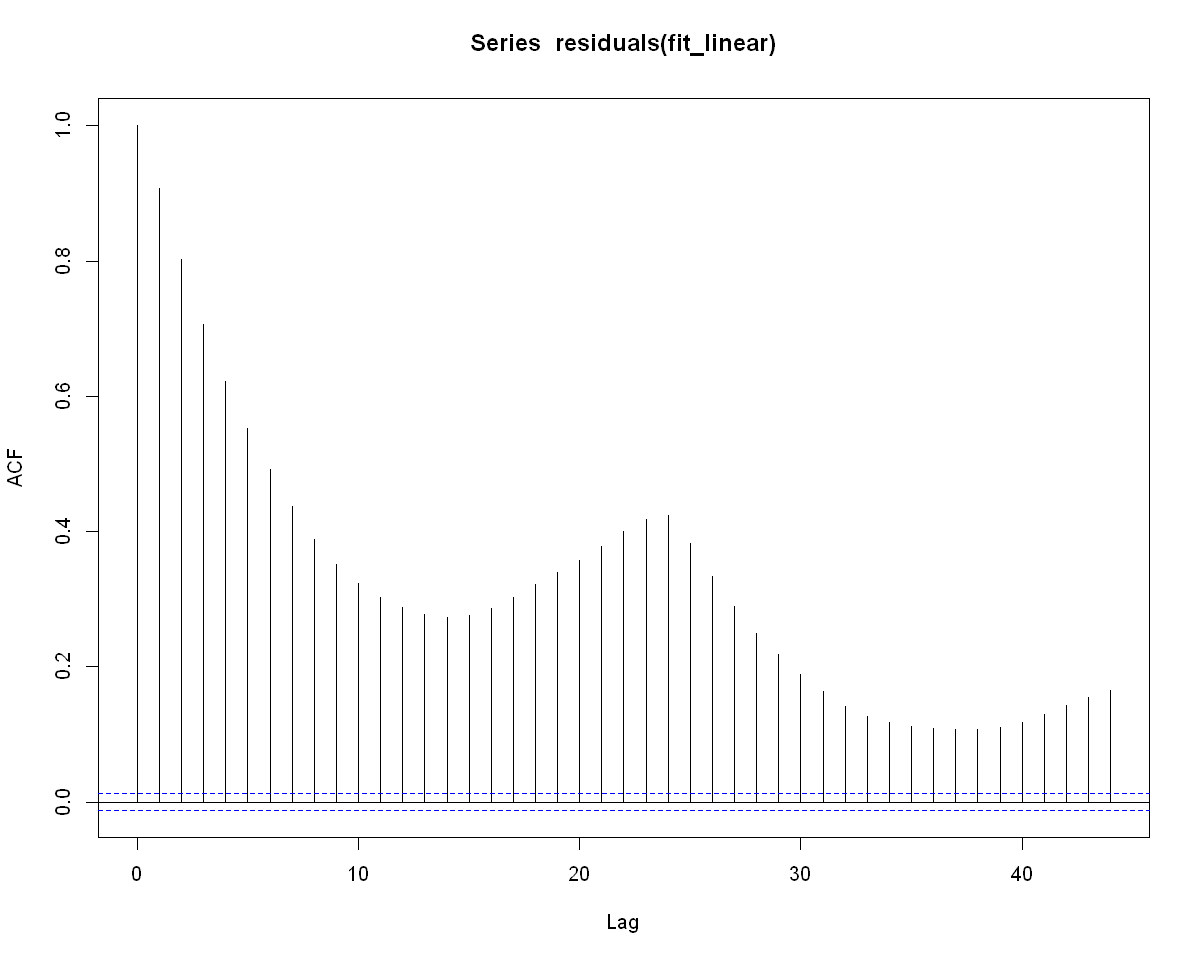

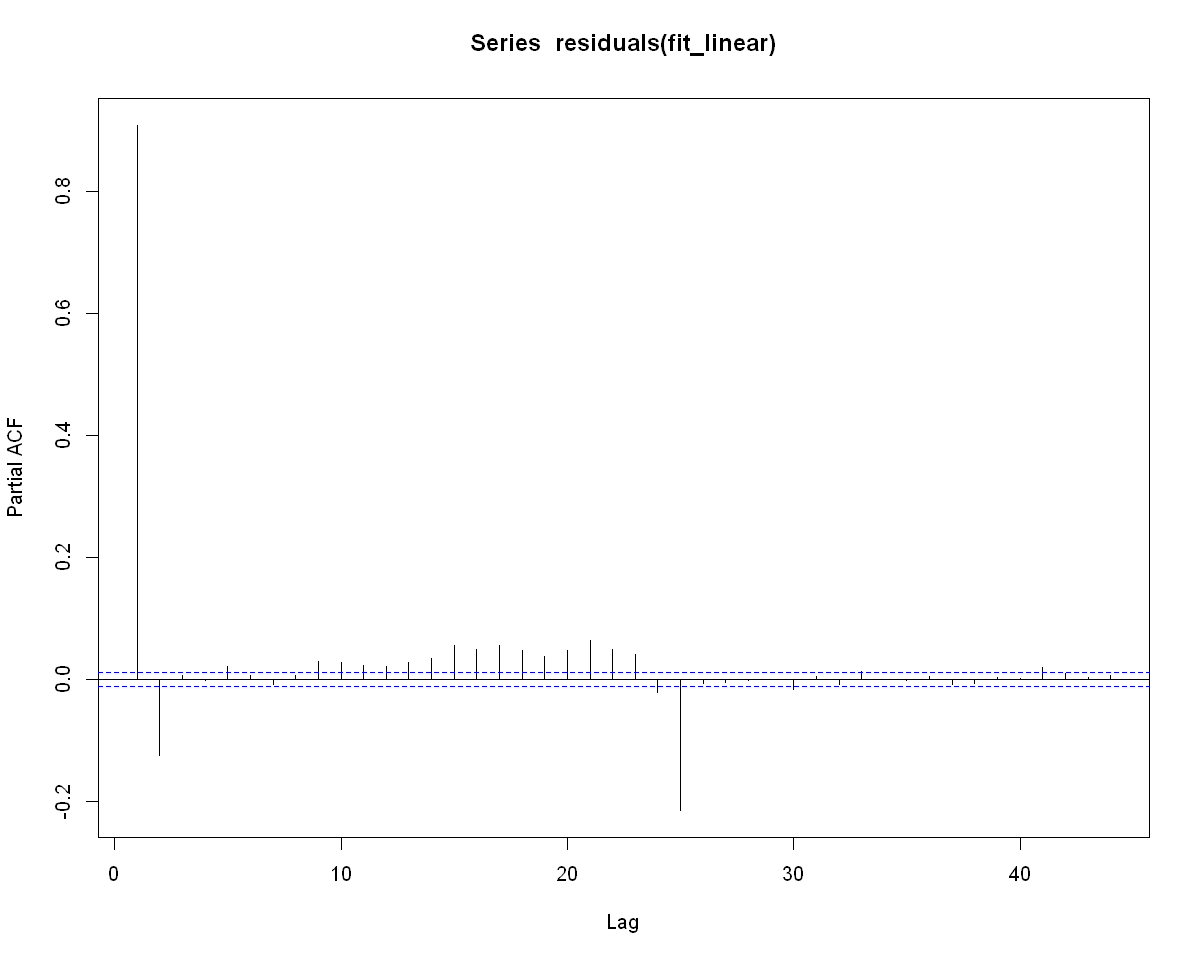

In [16]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour),train_data)
summary(fit_linear)

plot(residuals(fit_linear))
acf(residuals(fit_linear))
pacf(residuals(fit_linear))

In [17]:
colnames(data)

[1] "date"                    "hour"                   
 [3] "net"                     "upRegulationZeroCoded"  
 [5] "upRegulationOneCoded"    "upRegulationTwoCoded"   
 [7] "downRegulationZeroCoded" "downRegulationOneCoded" 
 [9] "downRegulationTwoCoded"  "upRegulationDelivered"  
[11] "downRegulationDelivered" "system_direction"       
[13] "time"                    "DSWRF_surface"          
[15] "RH_2.m.above.ground"     "TMP_2.m.above.ground"   
[17] "TCDC_low.cloud.layer"    "ws_10m"                 
[19] "wdir_10m"                "weekdays"               
[21] "months"                  "years"                  
[23] "trend"                   "lag_1"


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2263.0  -219.9     2.8   214.5  3274.9 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -2.209e+02  1.719e+01 -12.847  < 2e-16 ***
weekdaysMonday     6.451e+00  9.531e+00   0.677   0.4985    
weekdaysSaturday  -2.609e+00  9.522e+00  -0.274   0.7841    
weekdaysSunday    -2.381e+01  9.573e+00  -2.488   0.0129 *  
weekdaysThursday   1.584e+01  9.515e+00   1.664   0.0960 .  
weekdaysTuesday    1.188e+01  9.516e+00   1.248   0.2121    
weekdaysWednesday  1.201e+01  9.515e+00   1.262   0.2070    
months2            1.151e+01  1.534e+01   0.750   0.4532    
months3            8.368e+00  2.123e+01   0.394   0.6935    
months4           -3.143e+00  2.893e+01  -0.109   0.9135    
months5            8.161e+00  3.708e+01   0.220   0.8258    
months6            2.955e+01  4.555e+01   0.649 

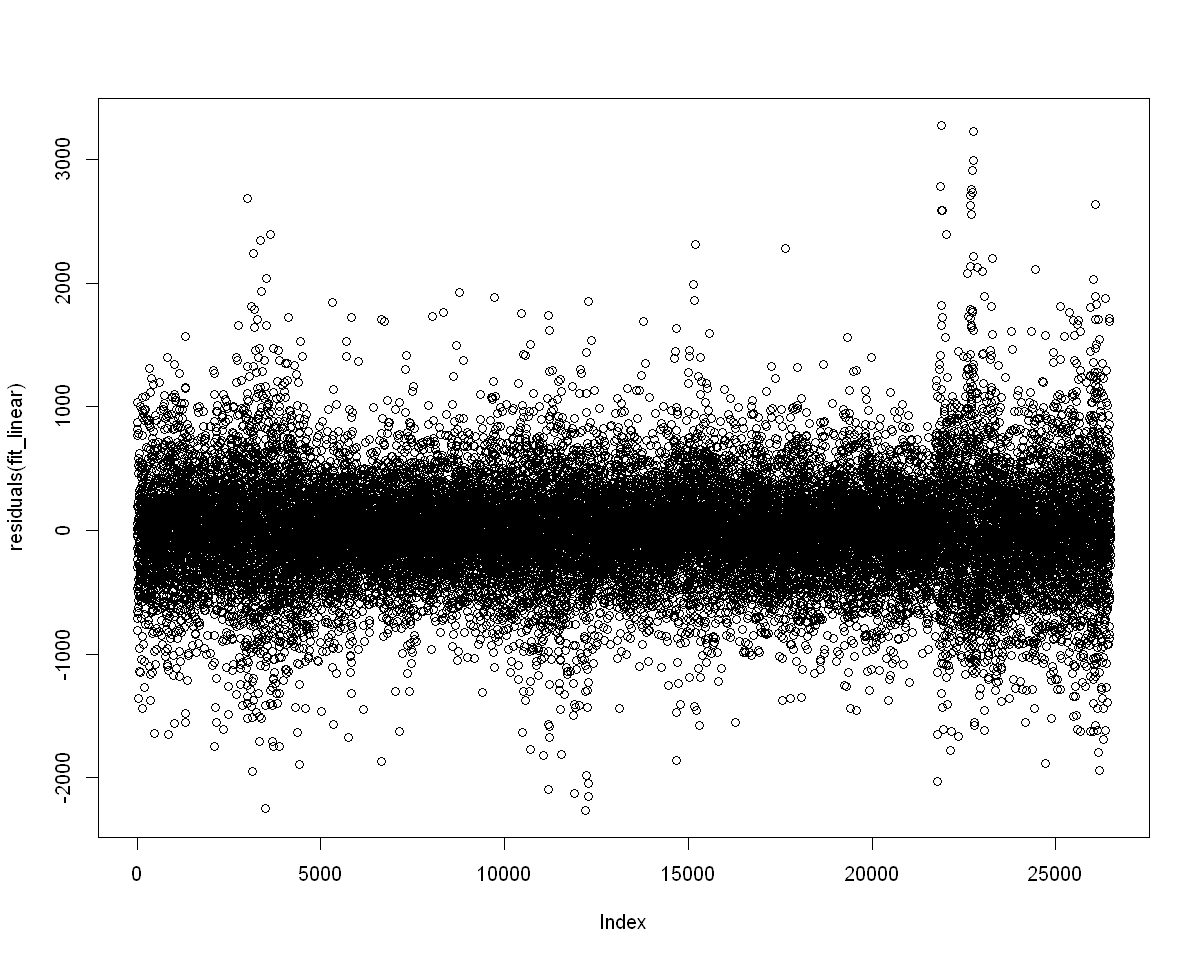

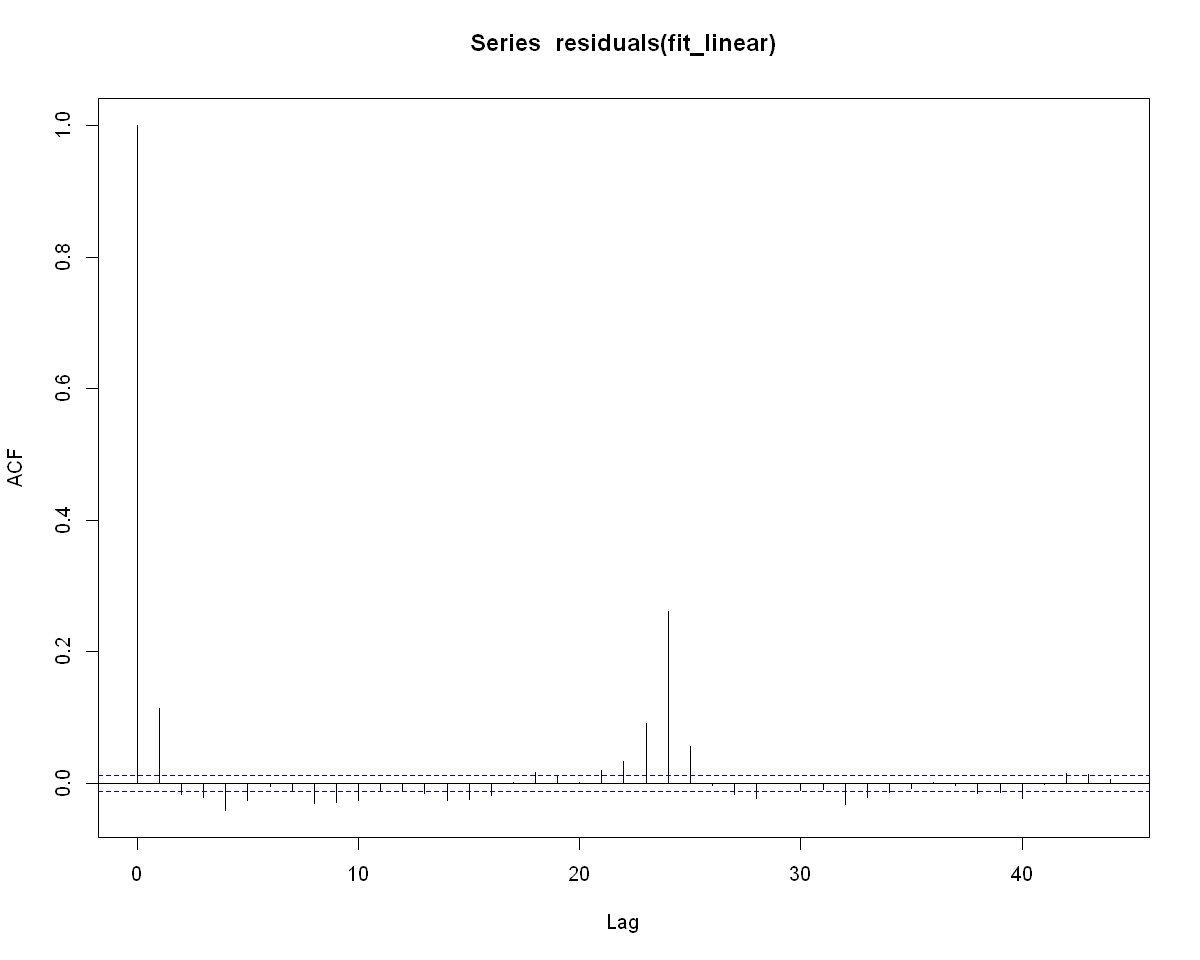

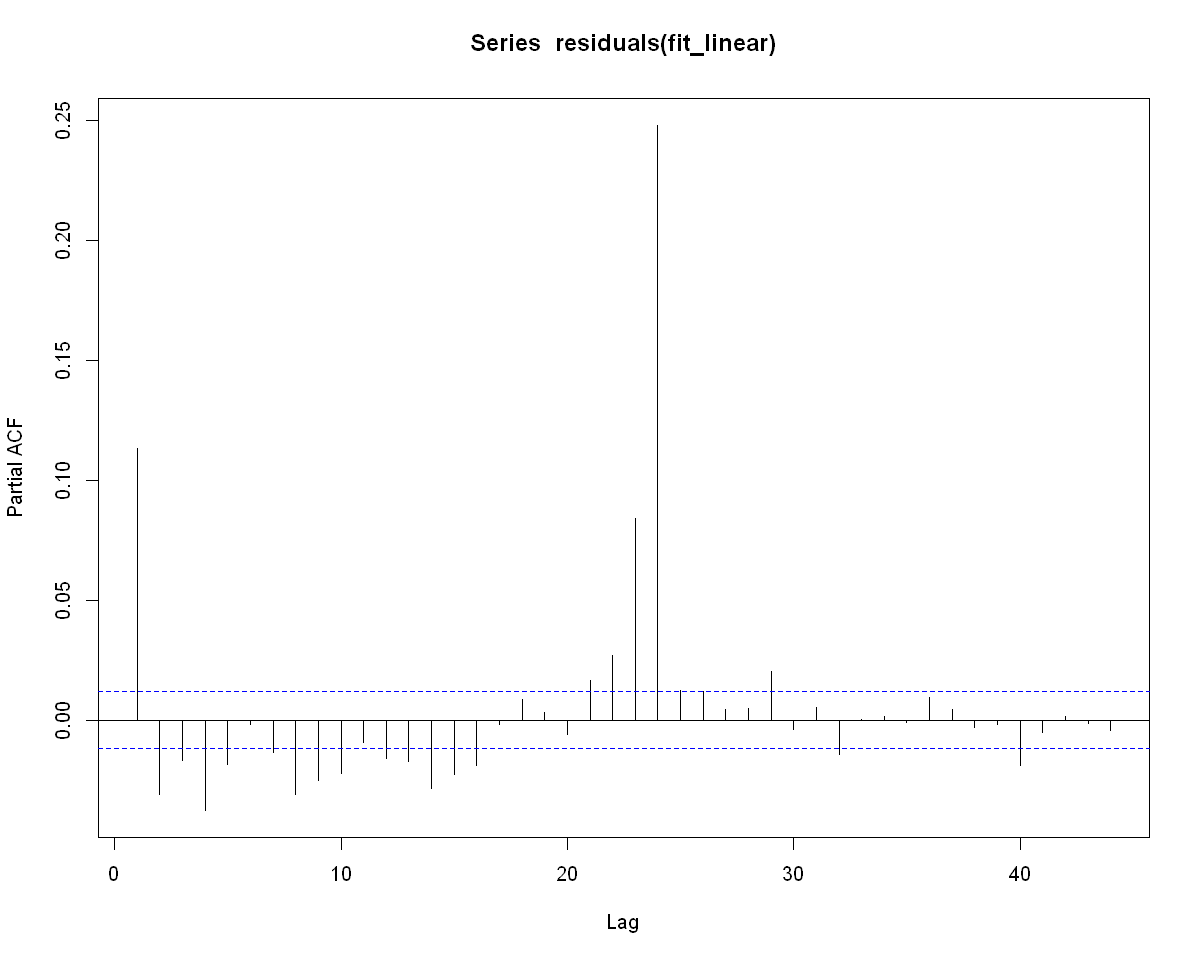

In [18]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1,train_data)
summary(fit_linear)

plot(residuals(fit_linear))
acf(residuals(fit_linear))
pacf(residuals(fit_linear))

In [19]:
tmp=copy(train_data)
colnames(tmp)
#head(tmp)

[1] "date"                    "hour"                   
 [3] "net"                     "upRegulationZeroCoded"  
 [5] "upRegulationOneCoded"    "upRegulationTwoCoded"   
 [7] "downRegulationZeroCoded" "downRegulationOneCoded" 
 [9] "downRegulationTwoCoded"  "upRegulationDelivered"  
[11] "downRegulationDelivered" "system_direction"       
[13] "time"                    "DSWRF_surface"          
[15] "RH_2.m.above.ground"     "TMP_2.m.above.ground"   
[17] "TCDC_low.cloud.layer"    "ws_10m"                 
[19] "wdir_10m"                "weekdays"               
[21] "months"                  "years"                  
[23] "trend"                   "lag_1"

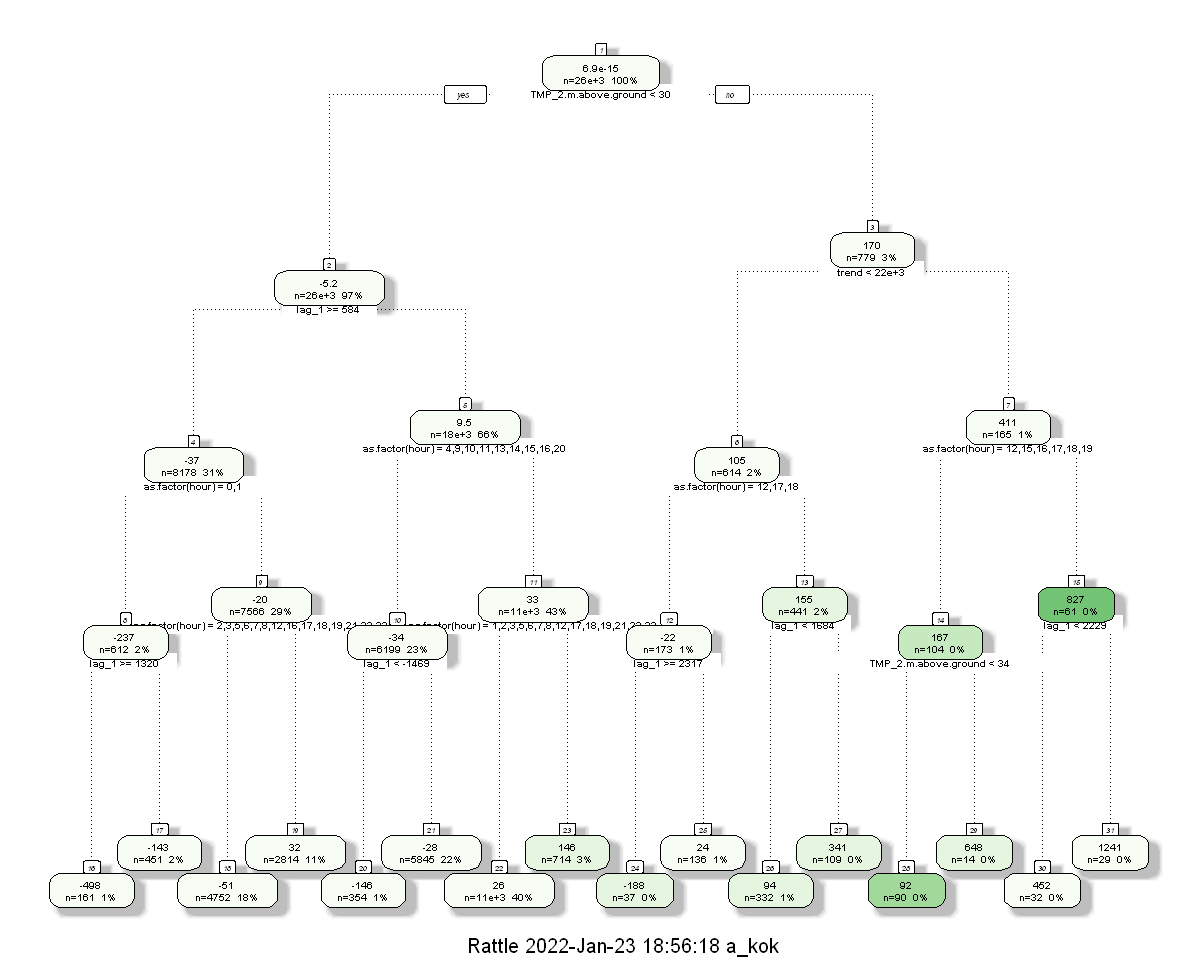

In [20]:
tmp[2:.N,residual:=residuals(fit_linear)]


fit_res_tree=rpart(residual~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                   DSWRF_surface + RH_2.m.above.ground + TMP_2.m.above.ground + TCDC_low.cloud.layer +
                   ws_10m + wdir_10m,tmp,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree,cex=0.5)

In [21]:
tmp[,tmp_30:=as.numeric(TMP_2.m.above.ground>30)]
tmp[,trend_22:=as.numeric(trend>22e+3)]
tmp[,hour_12_15:=as.numeric(!as.factor(hour)%in% c(12,15,16,17,18,19))]
tmp[,lag_1_2229:=as.numeric(lag_1>2229)]

In [22]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229, data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-2277.7  -219.1     2.9   215.6  3297.6 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -2.206e+02  1.711e+01 -12.895  < 2e-16
weekdaysMonday                         8.686e+00  9.483e+00   0.916   0.3597
weekdaysSaturday                      -1.378e+00  9.474e+00  -0.146   0.8843
weekdaysSunday                        -2.298e+01  9.524e+00  -2.413   0.0158
weekdaysThursday                       1.685e+01  9.467e+00   1.780   0.0751
weekdaysTuesday                        1.408e+01  9.468e+00   1.487   0.1370
weekdaysWednesday                      1.334e+01  9.466e+00   1.409   0.1587
months2                                1.106e+01  1.526e+01   0.725   0.4685
months3                                6.357e+00  2.11

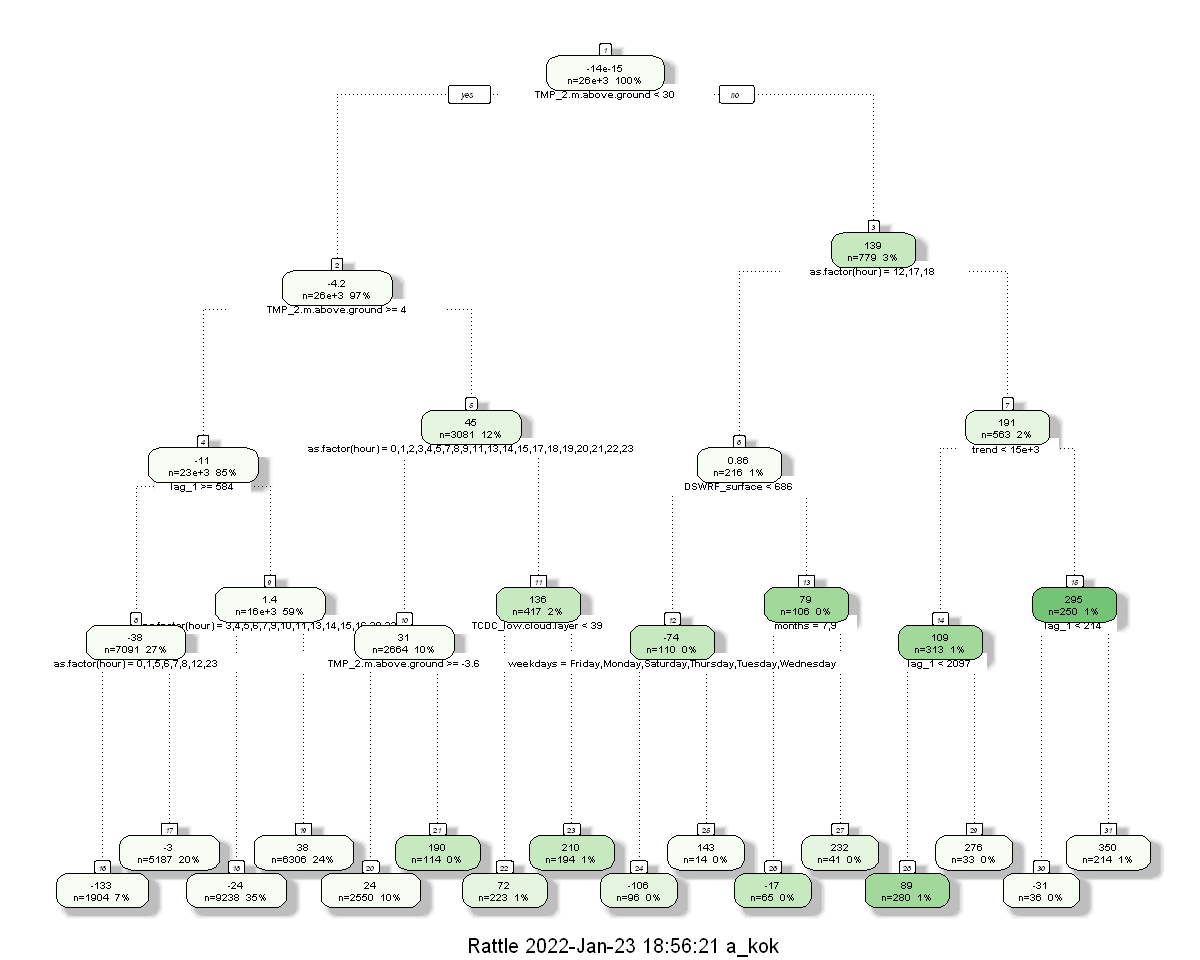

In [23]:
tmp[2:.N,residual:=residuals(fit_linear)]


fit_res_tree=rpart(residual~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                   DSWRF_surface + RH_2.m.above.ground + TMP_2.m.above.ground + TCDC_low.cloud.layer +
                   ws_10m + wdir_10m,tmp,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree,cex=0.5)

In [24]:
tmp[,hour_12_17:=as.numeric(!as.factor(hour)%in% c(12,17,18))]
tmp[,trend_15:=as.numeric(trend>15e+3)]
tmp[,lag_1_214:=as.numeric(lag_1>214)]

In [25]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229 + tmp_30:hour_12_17:trend_15:lag_1_214, 
    data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-2290.2  -219.3     3.7   216.7  3322.7 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -2.156e+02  1.707e+01 -12.628  < 2e-16
weekdaysMonday                         8.365e+00  9.459e+00   0.884   0.3765
weekdaysSaturday                      -1.746e+00  9.450e+00  -0.185   0.8534
weekdaysSunday                        -2.422e+01  9.501e+00  -2.549   0.0108
weekdaysThursday                       1.713e+01  9.443e+00   1.814   0.0698
weekdaysTuesday                        1.333e+01  9.445e+00   1.412   0.1581
weekdaysWednesday                      1.324e+01  9.442e+00   1.402   0.1609
months2                                1.307e+01  1.522e+01   0.859   0.3905
months3   

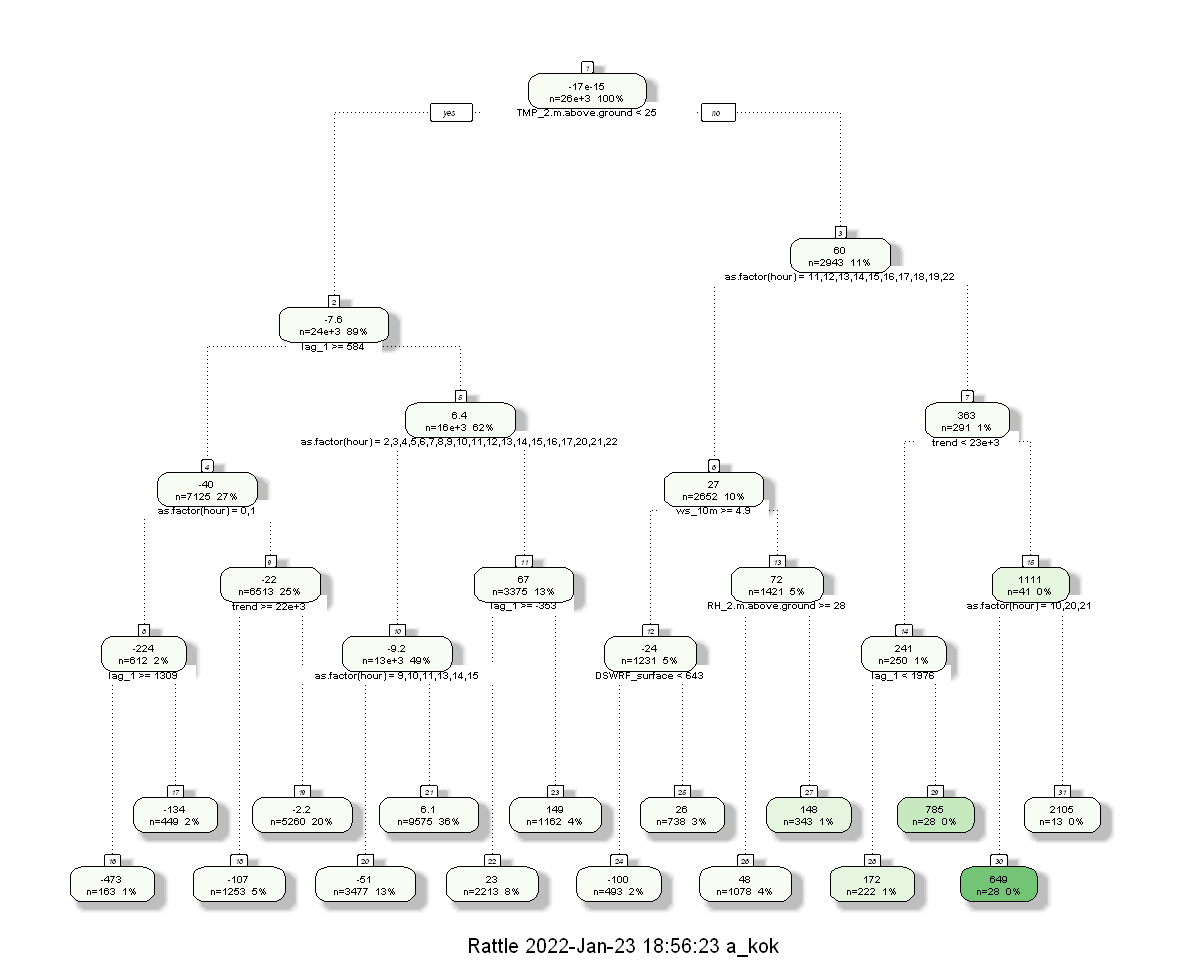

In [26]:
tmp[2:.N,residual:=residuals(fit_linear)]


fit_res_tree=rpart(residual~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                   DSWRF_surface + RH_2.m.above.ground + TMP_2.m.above.ground + TCDC_low.cloud.layer +
                   ws_10m + wdir_10m,tmp,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree,cex=0.5)

In [27]:
tmp[,tmp_25:=as.numeric(TMP_2.m.above.ground>25)]
tmp[,hour_11_12:=as.numeric(!as.factor(hour)%in%c(11,12,13,14,15,16,17,18,19,22))]
tmp[,trend_23:=as.numeric(trend>23e+3)]
tmp[,hour_10_20:=as.numeric(!as.factor(hour)%in%c(10,20,21))]

In [28]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229 + tmp_30:hour_12_17:trend_15:lag_1_214 + 
    tmp_25:hour_11_12:trend_23:hour_10_20, data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-2286.6  -219.3     4.0   216.4  3326.1 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -2.149e+02  1.706e+01 -12.592  < 2e-16
weekdaysMonday                         8.586e+00  9.456e+00   0.908   0.3639
weekdaysSaturday                      -1.932e+00  9.446e+00  -0.205   0.8379
weekdaysSunday                        -2.419e+01  9.497e+00  -2.548   0.0109
weekdaysThursday                       1.713e+01  9.439e+00   1.814   0.0696
weekdaysTuesday                        1.354e+01  9.441e+00   1.434   0.1517
weekdaysWednesday                      1.322e+01  9.439e+00   1.401   0.1612
months2                                1.375e+0

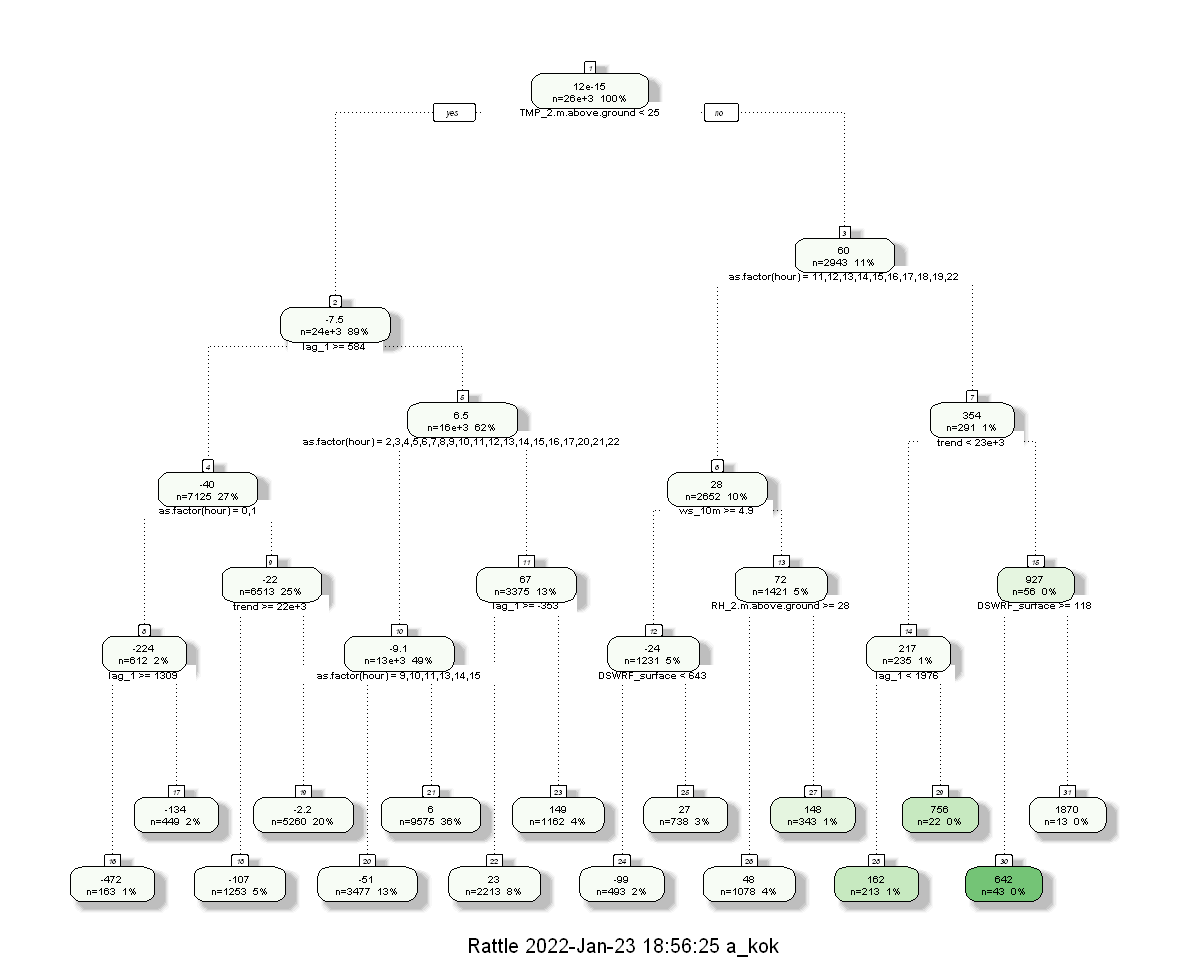

In [29]:
tmp[2:.N,residual:=residuals(fit_linear)]


fit_res_tree=rpart(residual~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                   DSWRF_surface + RH_2.m.above.ground + TMP_2.m.above.ground + TCDC_low.cloud.layer +
                   ws_10m + wdir_10m,tmp,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree,cex=0.5)

In [30]:
tmp[,dswrf_118:=as.numeric(DSWRF_surface>=118)]

In [31]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20 +
                tmp_25:hour_11_12:trend_23:dswrf_118,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229 + tmp_30:hour_12_17:trend_15:lag_1_214 + 
    tmp_25:hour_11_12:trend_23:hour_10_20 + tmp_25:hour_11_12:trend_23:dswrf_118, 
    data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-2287.1  -219.2     4.2   216.3  3326.4 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                           -2.140e+02  1.706e+01 -12.543  < 2e-16
weekdaysMonday                         8.729e+00  9.453e+00   0.923   0.3558
weekdaysSaturday                      -1.927e+00  9.443e+00  -0.204   0.8383
weekdaysSunday                        -2.422e+01  9.494e+00  -2.551   0.0108
weekdaysThursday                       1.713e+01  9.436e+00   1.816   0.0694
weekdaysTuesday                        1.354e+01  9.438e+00   1.435   0.1514
weekdaysWednesday                      1.320e+01  9.436e+00   1.399   0.1617
mon

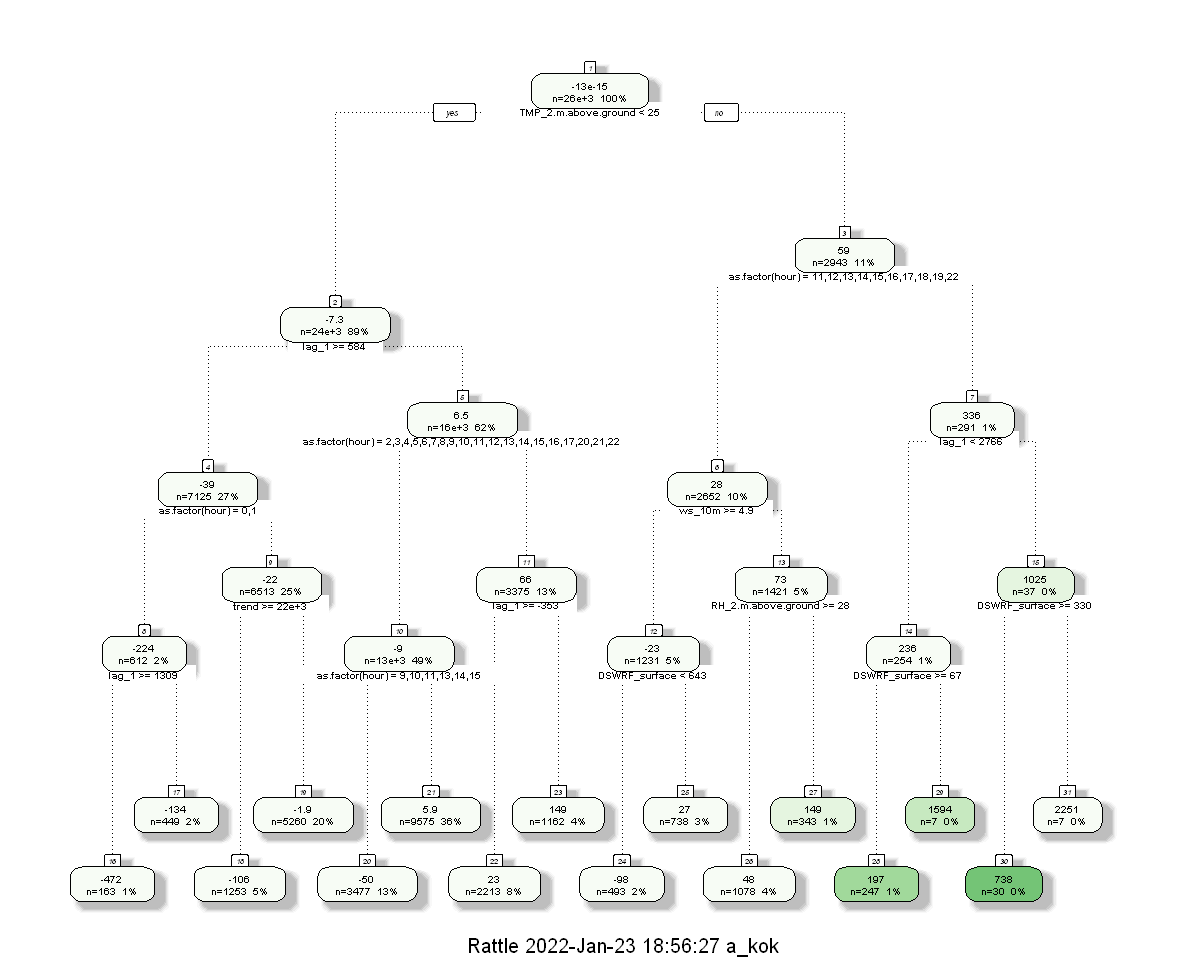

In [32]:
tmp[2:.N,residual:=residuals(fit_linear)]


fit_res_tree=rpart(residual~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                   DSWRF_surface + RH_2.m.above.ground + TMP_2.m.above.ground + TCDC_low.cloud.layer +
                   ws_10m + wdir_10m,tmp,
                   control=rpart.control(cp=0,maxdepth=4))

fancyRpartPlot(fit_res_tree,cex=0.5)

In [33]:
tmp[,tmp_25:=as.numeric(TMP_2.m.above.ground>25)]
tmp[,lag_1_2766:=as.numeric(lag_1>2766)]
tmp[,dswrf_330:=as.numeric(DSWRF_surface<330)]

In [34]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20 +
                tmp_25:hour_11_12:trend_23:dswrf_118 +
                tmp_25:hour_11_12:lag_1_2766:dswrf_330,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229 + tmp_30:hour_12_17:trend_15:lag_1_214 + 
    tmp_25:hour_11_12:trend_23:hour_10_20 + tmp_25:hour_11_12:trend_23:dswrf_118 + 
    tmp_25:hour_11_12:lag_1_2766:dswrf_330, data = tmp)

Residuals:
    Min      1Q  Median      3Q     Max 
-2282.9  -218.4     4.5   216.8  3273.6 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                            -2.148e+02  1.699e+01 -12.639  < 2e-16
weekdaysMonday                          9.925e+00  9.415e+00   1.054   0.2918
weekdaysSaturday                       -9.802e-01  9.406e+00  -0.104   0.9170
weekdaysSunday                         -2.372e+01  9.456e+00  -2.508   0.0121
weekdaysThursday                        1.665e+01  9.398e+00   1.772   0.0765
weekdaysTuesday                         1.420e+01  9.401e+00   1.511   0.1308
weekdaysWednesday               

In [35]:
tmp$residual[2:length(tmp$net)] <- fit_linear$residual
tmp[!is.na(residual), quant5:=quantile(residual, 0.05)]
tmp[!is.na(residual), quant95:=quantile(residual, 0.95)]
tmp[,outlier_small:= as.numeric(residual < quant5)]
tmp[,outlier_great:= as.numeric(residual > quant95)]

In [36]:
fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20 +
                tmp_25:hour_11_12:trend_23:dswrf_118 +
                tmp_25:hour_11_12:lag_1_2766:dswrf_330 +
                outlier_small + outlier_great,tmp)
summary(fit_linear)


Call:
lm(formula = net ~ weekdays + months + years + trend + as.factor(hour) + 
    lag_1 + tmp_30:trend_22:hour_12_15:lag_1_2229 + tmp_30:hour_12_17:trend_15:lag_1_214 + 
    tmp_25:hour_11_12:trend_23:hour_10_20 + tmp_25:hour_11_12:trend_23:dswrf_118 + 
    tmp_25:hour_11_12:lag_1_2766:dswrf_330 + outlier_small + 
    outlier_great, data = tmp)

Residuals:
     Min       1Q   Median       3Q      Max 
-1347.43  -185.98     3.58   183.93  2345.90 

Coefficients:
                                         Estimate Std. Error  t value Pr(>|t|)
(Intercept)                            -2.153e+02  1.177e+01  -18.288  < 2e-16
weekdaysMonday                          1.098e+01  6.495e+00    1.690  0.09105
weekdaysSaturday                        9.480e+00  6.490e+00    1.461  0.14408
weekdaysSunday                         -1.941e+01  6.524e+00   -2.976  0.00293
weekdaysThursday                        1.549e+01  6.485e+00    2.389  0.01689
weekdaysTuesday                         9.208e+00  6.485e

In [37]:
data[,tmp_30:=as.numeric(TMP_2.m.above.ground>30)]
data[,trend_22:=as.numeric(trend>22e+3)]
data[,hour_12_15:=as.numeric(!as.factor(hour)%in% c(12,15,16,17,18,19))]
data[,lag_1_2229:=as.numeric(lag_1>2229)]
data[,hour_12_17:=as.numeric(!as.factor(hour)%in% c(12,17,18))]
data[,trend_15:=as.numeric(trend>15e+3)]
data[,lag_1_214:=as.numeric(lag_1>214)]
data[,tmp_25:=as.numeric(TMP_2.m.above.ground>25)]
data[,hour_11_12:=as.numeric(!as.factor(hour)%in%c(11,12,13,14,15,16,17,18,19,22))]
data[,trend_23:=as.numeric(trend>23e+3)]
data[,hour_10_20:=as.numeric(!as.factor(hour)%in%c(10,20,21))]
data[,tmp_25:=as.numeric(TMP_2.m.above.ground>25)]
data[,lag_1_2766:=as.numeric(lag_1>2766)]
data[,dswrf_330:=as.numeric(DSWRF_surface<330)]
data[,dswrf_118:=as.numeric(DSWRF_surface>=118)]
data[,outlier_small:=0]
data[,outlier_great:=0]

In [38]:
for(j in 0:13){
test_data = data[date == (as.Date("2022-01-09") + j)]
tmp = data[date <= (as.Date("2022-01-08") + j)]


fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20 +
                tmp_25:hour_11_12:trend_23:dswrf_118 +
                tmp_25:hour_11_12:lag_1_2766:dswrf_330,tmp)

tmp$residual[2:length(tmp$net)] <- fit_linear$residual
tmp[!is.na(residual), quant5:=quantile(residual, 0.05)]
tmp[!is.na(residual), quant95:=quantile(residual, 0.95)]
tmp[,outlier_small:= as.numeric(residual < quant5)]
tmp[,outlier_great:= as.numeric(residual > quant95)]

fit_linear = lm(net~weekdays + months + years + trend + as.factor(hour) + lag_1 +
                tmp_30:trend_22:hour_12_15:lag_1_2229 +
                tmp_30:hour_12_17:trend_15:lag_1_214 +
                tmp_25:hour_11_12:trend_23:hour_10_20 +
                tmp_25:hour_11_12:trend_23:dswrf_118 +
                tmp_25:hour_11_12:lag_1_2766:dswrf_330 +
                outlier_small + outlier_great,tmp)

test_data[hour == 0,lag_1:=tmp[.N]$net]

for(i in 0:22){
test_data[hour == i,predicted:=predict(fit_linear,newdata = test_data[hour == i])]
test_data[hour == i + 1,lag_1:=test_data[hour == i]$predicted]
}

test_data[hour == 23,predicted:=predict(fit_linear,newdata = test_data[hour == 23])]
test_data[hour >= 12 & predicted < -50 ,system_direction_predicted:="Negative"]
test_data[hour >= 12 & predicted > 50 ,system_direction_predicted:="Positive"]
test_data[hour >= 12 & predicted <= 50 & predicted>=-50 ,system_direction_predicted:="Neutral"]
prediction = test_data[hour>=12]$system_direction_predicted
data[date == (as.Date("2022-01-09") + j) & hour>=12,"system_direction_predicted"] = prediction
}


In [39]:
daily_accuracy <- c()
for(j in 0:12){
    actual = data[hour >= 12 & date == (as.Date("2022-01-09") + j)]$system_direction
    predicted = data[hour >= 12 & date == (as.Date("2022-01-09") + j)]$system_direction_predicted
    accuracy = sum(actual == predicted)/12
    daily_accuracy <- c(daily_accuracy,accuracy)
}
daily_accuracy = as.data.table(daily_accuracy)
base_daily_accuracy <- c()
for(j in 0:12){
    actual = data[hour >= 12 & date == (as.Date("2022-01-09") + j)]$system_direction
    predicted = data[hour >= 12 & date == (as.Date("2022-01-09") + j -  1)]$system_direction
    accuracy = sum(actual == predicted)/12
    base_daily_accuracy <- c(base_daily_accuracy,accuracy)
}
base_daily_accuracy = as.data.table(base_daily_accuracy)
base_2_daily_accuracy <- c()
for(j in 0:12){
    actual = data[hour >= 12 & date == (as.Date("2022-01-09") + j)]$system_direction
    predicted = data[hour >= 12 & date == (as.Date("2022-01-09") + j -  7)]$system_direction
    accuracy = sum(actual == predicted)/12
    base_2_daily_accuracy <- c(base_2_daily_accuracy,accuracy)
}
base_2_daily_accuracy = as.data.table(base_2_daily_accuracy)

In [40]:
daily_accuracy = cbind(daily_accuracy,base_daily_accuracy)
daily_accuracy = cbind(daily_accuracy,base_2_daily_accuracy)
daily_accuracy[,"date"] = unique(data[date>= "2022-01-09" & date <= "2022-01-21"]$date)

In [41]:
daily_accuracy

daily_accuracy,base_daily_accuracy,base_2_daily_accuracy,date
<dbl>,<dbl>,<dbl>,<date>
0.7500000,0.7500000,0.5000000,2022-01-09
0.6666667,0.5000000,0.8333333,2022-01-10
1.0000000,0.6666667,0.5000000,2022-01-11
1.0000000,1.0000000,0.3333333,2022-01-12
0.8333333,0.8333333,0.8333333,2022-01-13
0.2500000,0.4166667,0.3333333,2022-01-14
0.9166667,0.2500000,0.9166667,2022-01-15
0.7500000,0.6666667,0.8333333,2022-01-16
0.4166667,0.1666667,0.5833333,2022-01-17


In [42]:
overall_accuracy = daily_accuracy[1]
overall_accuracy[,date:=NULL]
overall_accuracy[1,1] = mean(daily_accuracy$daily_accuracy)
overall_accuracy[1,2] = mean(daily_accuracy$base_daily_accuracy)
overall_accuracy[1,3] = mean(daily_accuracy$base_2_daily_accuracy)
colnames(overall_accuracy) = c("method","base","base_2")

In [45]:
overall_accuracy

method,base,base_2
<dbl>,<dbl>,<dbl>
0.8141026,0.6666667,0.6730769
